## Dependencies

In [1]:
import warnings
import pandas as pd 
from WeightOfEvidenceScoring import frequency_table
from WeightOfEvidenceScoring import DiscreteNormalizer
from WeightOfEvidenceScoring import Discretizer
from WeightOfEvidenceScoring import WoeEncoder
from WeightOfEvidenceScoring import WoeContinuousFeatureSelector
from WeightOfEvidenceScoring import WoeDiscreteFeatureSelector
from WeightOfEvidenceScoring import CreditScoring
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import seaborn as sns
warnings.filterwarnings('ignore')

## Reading example data

In [2]:
t = pd.read_csv('train.csv')
v = pd.read_csv('valid.csv')   

## Defining feature type

In [3]:
vard = [v for v in t.columns if v[:2]=='D_']
varc = [v for v in t.columns if v[:2]=='C_']

## Normalize Discrete Features

In [4]:
dn = DiscreteNormalizer()

In [5]:
dn.fit(t[vard])

In [6]:
Xt = dn.transform(t[vard])

In [7]:
frequency_table(Xt,vard)

****Frequency Table  D_OCCUPATION_TYPE  ***


             Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
Core staff           83       0.083                83             0.083
Drivers              67       0.067               150             0.150
Laborers            166       0.166               316             0.316
MISSING             325       0.325               641             0.641
Managers             70       0.070               711             0.711
OTHER               175       0.175               886             0.886
Sales staff         114       0.114              1000             1.000




****Frequency Table  D_NAME_CONTRACT_TYPE  ***


                 Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
Cash loans              897       0.897               897             0.897
Revolving loans         103       0.103              1000             1.000




****Frequency Table  D_CODE_GENDER  ***


   Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. 

In [8]:
unary = [v for v in vard if Xt[v].nunique==1]
unary

[]

## WoE Based Best Feature Selection

In [9]:
Xt = pd.concat([Xt,t[varc]],axis=1)

In [10]:
wcf = WoeContinuousFeatureSelector()
wdf = WoeDiscreteFeatureSelector()

In [11]:
wcf.fit(Xt[varc],t['TARGET'],strictly_monotonic=True,iv_threshold=0.05,method='dec',n_threads=20)
wdf.fit(Xt[vard],t['TARGET'],iv_threshold=0.1)

In [12]:
Xt = pd.concat([wdf.transform(Xt[vard]),wcf.transform(Xt[varc])],axis=1)

In [13]:
var = list(Xt.columns)

In [14]:
var

['D_CODE_GENDER',
 'disc_C_AMT_CREDIT_4_gaussian',
 'disc_C_AMT_CREDIT_4_kmeans',
 'disc_C_AMT_CREDIT_3_quantile',
 'disc_C_AMT_INCOME_TOTAL_3_gaussian']

In [15]:
wcf.selected_features

[{'feature': 'disc_C_AMT_CREDIT_4_gaussian',
  'iv': 0.0620354419480231,
  'root_feature': 'C_AMT_CREDIT',
  'nbins': '4',
  'method': 'gaussian'},
 {'feature': 'disc_C_AMT_CREDIT_4_kmeans',
  'iv': 0.08944178361036469,
  'root_feature': 'C_AMT_CREDIT',
  'nbins': '4',
  'method': 'kmeans'},
 {'feature': 'disc_C_AMT_CREDIT_3_quantile',
  'iv': 0.07455217706705206,
  'root_feature': 'C_AMT_CREDIT',
  'nbins': '3',
  'method': 'quantile'},
 {'feature': 'disc_C_AMT_INCOME_TOTAL_3_gaussian',
  'iv': 0.07962740474700439,
  'root_feature': 'C_AMT_INCOME_TOTAL',
  'nbins': '3',
  'method': 'gaussian'}]

In [16]:
wdf.selected_features

{'D_CODE_GENDER': 0.10698023203218116}

## WoE Transformation

In [17]:
we = WoeEncoder()

In [18]:
we.fit(Xt[var],t['TARGET'])

In [19]:
Xwt = we.transform(Xt[var])

## Parameter Learning

In [20]:
lr = LogisticRegression()

In [21]:
lr.fit(Xwt,t['TARGET'])

LogisticRegression()

In [22]:
Xwt

,D_CODE_GENDER,disc_C_AMT_CREDIT_4_gaussian,disc_C_AMT_CREDIT_4_kmeans,disc_C_AMT_CREDIT_3_quantile,disc_C_AMT_INCOME_TOTAL_3_gaussian
0,-0.397247,0.138010,0.092313,0.146261,-0.095193
1,0.271721,-0.351785,0.092313,-0.320138,-0.095193
2,0.271721,-0.351785,-0.303484,-0.320138,-0.095193
3,0.271721,-0.351785,-0.303484,-0.320138,-0.095193
4,0.271721,0.138010,0.092313,0.146261,-0.095193
...,...,...,...,...,...
995,-0.397247,0.138010,0.092313,-0.320138,-0.095193
996,0.271721,0.242872,-0.336037,0.309964,-0.569651
997,0.271721,0.187212,-0.303484,-0.320138,-0.095193
998,0.271721,-0.351785,0.092313,-0.320138,0.424632


In [23]:
roc_auc_score(y_score=lr.predict_proba(Xwt)[:,1],y_true=t['TARGET'])

0.6509046708114139

## Scoring

In [24]:
cs = CreditScoring()

In [25]:
cs.fit(Xwt,we,lr)

In [26]:
cs.scorecard

points
feature                            attribute                       
D_CODE_GENDER                      F                             73
                                   M                             55
disc_C_AMT_CREDIT_3_quantile       (327024.0, 675000.0]          62
                                   (47969.999, 327024.0]         67
                                   (675000.0, 2370559.5]         69
disc_C_AMT_CREDIT_4_gaussian       (370629.0, 652500.0]          63
                                   (47969.999, 370629.0]         67
                                   (652500.0, 983299.5]          67
                                   (983299.5, 2370559.5]         68
disc_C_AMT_CREDIT_4_kmeans         (1381796.72, 2370559.5]       60
                                   (456025.115, 869398.644]      60
                                   (47969.999, 456025.115]       67
                                   (869398.644, 1381796.72]      77
disc_C_AMT_INCOME_TOTAL_3_gaussian (173250.0, 306000.0]          77
                                   (28403.999, 173250.0]         63
                                   (306000.0, 810000.0]          50

## Validation

In [27]:
Xv = pd.concat([wdf.transform(dn.transform(v[vard])),wcf.transform(v[varc])],axis=1)
Xwv = we.transform(Xv)

In [28]:
roc_auc_score(y_score=lr.predict_proba(Xwv)[:,1],y_true=v['TARGET'])

0.654511398055157

In [29]:
score = pd.concat([cs.transform(we.inverse_transform(Xwv))[['score']].assign(sample='validation'),
cs.transform(we.inverse_transform(Xwt))[['score']].assign(sample='train')],ignore_index=True)

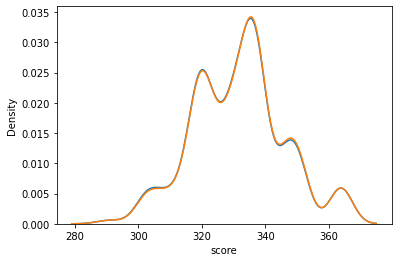

In [30]:
for s,d in score.groupby('sample'):
    sns.kdeplot(d['score'])